In [ ]:
!pip install git+https://github.com/huggingface/diffusers

In [ ]:
!git clone https://github.com/camlhui/inpainting-review.git

In [ ]:
from google.colab import drive
import os


drive.mount('/content/drive')

os.environ['DATA_DIR'] = '/content/drive/MyDrive/Colab storage/inpainting-review'
os.environ["HUGGING_FACE_CACHE_DIR"] = '/content/drive/MyDrive/Colab storage/hugging-face-cache'

In [4]:
import os
from google.colab import userdata


hf_hub_token = userdata.get("HUGGING_FACE_HUB_TOKEN")
assert hf_hub_token, "missing Google colab secret HUGGING_FACE_HUB_TOKEN"

os.environ["HUGGING_FACE_HUB_TOKEN"] = hf_hub_token

In [ ]:
%cd /content/inpainting-review/src

In [6]:
import json
import os
from inpainting_review.models import InpaintingTask
from inpainting_review.utils.image import load_and_preprocess_image, load_and_preprocess_mask


with open("inpainting_review/tasks.json") as f:
    tasks = [InpaintingTask(**t) for t in json.load(f)["tasks"]]

image = load_and_preprocess_image(os.path.join(os.environ['DATA_DIR'], tasks[0].source_image))
mask = load_and_preprocess_mask(os.path.join(os.environ['DATA_DIR'], tasks[0].mask_image))
prompt = tasks[0].prompt

# alimama-creative/SD3-Controlnet-Inpainting

https://huggingface.co/alimama-creative/SD3-Controlnet-Inpainting

In [ ]:
import torch
from diffusers.utils import load_image, check_min_version
from diffusers.pipelines import StableDiffusion3ControlNetInpaintingPipeline
from diffusers.models.controlnets.controlnet_sd3 import SD3ControlNetModel

controlnet = SD3ControlNetModel.from_pretrained(
    "alimama-creative/SD3-Controlnet-Inpainting",
    use_safetensors=True,
    extra_conditioning_channels=1,
    cache_dir=os.environ["HUGGING_FACE_CACHE_DIR"],

)
pipe = StableDiffusion3ControlNetInpaintingPipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    cache_dir=os.environ["HUGGING_FACE_CACHE_DIR"]
)
pipe.text_encoder.to(torch.float16)
pipe.controlnet.to(torch.float16)
pipe.to("cuda")

  0%|          | 0/28 [00:00<?, ?it/s]

(-0.5, 1023.5, 1023.5, -0.5)

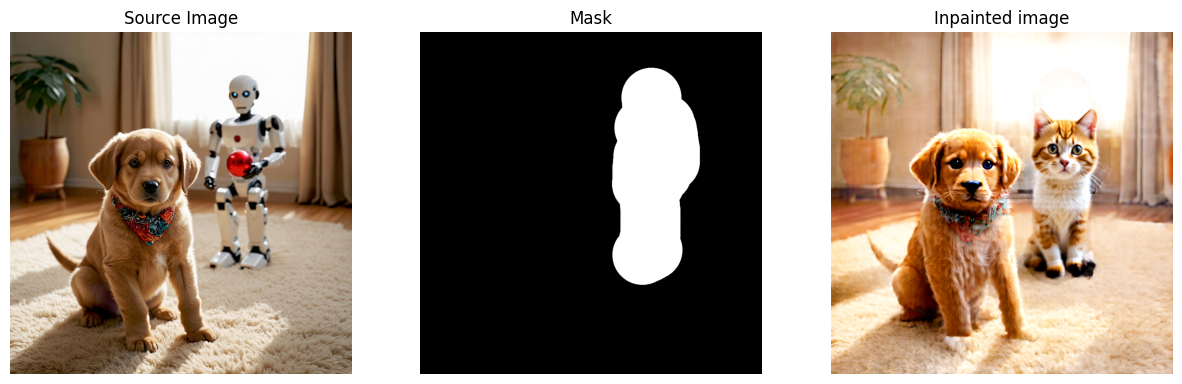

In [20]:
image = load_image(
    "https://huggingface.co/alimama-creative/SD3-Controlnet-Inpainting/resolve/main/images/dog.png"
)
mask = load_image(
    "https://huggingface.co/alimama-creative/SD3-Controlnet-Inpainting/resolve/main/images/dog_mask.png"
)
width = 1024
height = 1024
prompt = "A cat is sitting next to a puppy."

generator = torch.Generator(device="cuda").manual_seed(24)
res_image = pipe(
    negative_prompt="deformed, distorted, disfigured, poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, mutated hands and fingers, disconnected limbs, mutation, mutated, ugly, disgusting, blurry, amputation, NSFW",
    prompt=prompt,
    height=height,
    width=width,
    control_image=image,
    control_mask=mask,
    num_inference_steps=28,
    generator=generator,
    controlnet_conditioning_scale=0.95,
    guidance_scale=7,
).images[0]

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Source Image")
ax[0].axis("off")

ax[1].imshow(mask)
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(res_image)
ax[2].set_title("Inpainted image")
ax[2].axis("off")

## Configuration tuning

In [ ]:
import itertools

num_inference_steps_options = [28, 40]
controlnet_conditioning_scale_options = [0.6, 0.95]
guidance_scale_options = [5, 7, 9]

param_grid = list(itertools.product(
    num_inference_steps_options,
    controlnet_conditioning_scale_options,
    guidance_scale_options
))

results_dict = {}

output_dir = os.path.join(os.environ['DATA_DIR'], "outputs", "alimama-creative_SD3-Controlnet-Inpainting", "config_tuning")
os.makedirs(output_dir, exist_ok=True)

# Generate and store results
for params in param_grid:
    num_inference_steps, controlnet_conditioning_scale, guidance_scale = params
    for trial in range(3):  # Run 3 trials for each combination
        generator = torch.Generator(device="cuda").manual_seed(42 + trial)  # Change seed per trial
        result = pipe(
            prompt="A cat is sitting next to a puppy.",
            negative_prompt="deformed, distorted, disfigured, poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, mutated hands and fingers, disconnected limbs, mutation, mutated, ugly, disgusting, blurry, amputation, NSFW",
            height=1024,
            width=1024,
            control_image=image,
            control_mask=mask,
            num_inference_steps=num_inference_steps,
            controlnet_conditioning_scale=controlnet_conditioning_scale,
            guidance_scale=guidance_scale,
            generator=generator,
        )
        # Save result image
        filename = f"result_steps-{num_inference_steps}_condscale-{controlnet_conditioning_scale}_guidescale-{guidance_scale}_trial-{trial}.png"
        result.images[0].save(os.path.join(output_dir, filename))
        # Store results in dictionary
        results_dict[(num_inference_steps, controlnet_conditioning_scale, guidance_scale, trial)] = filename


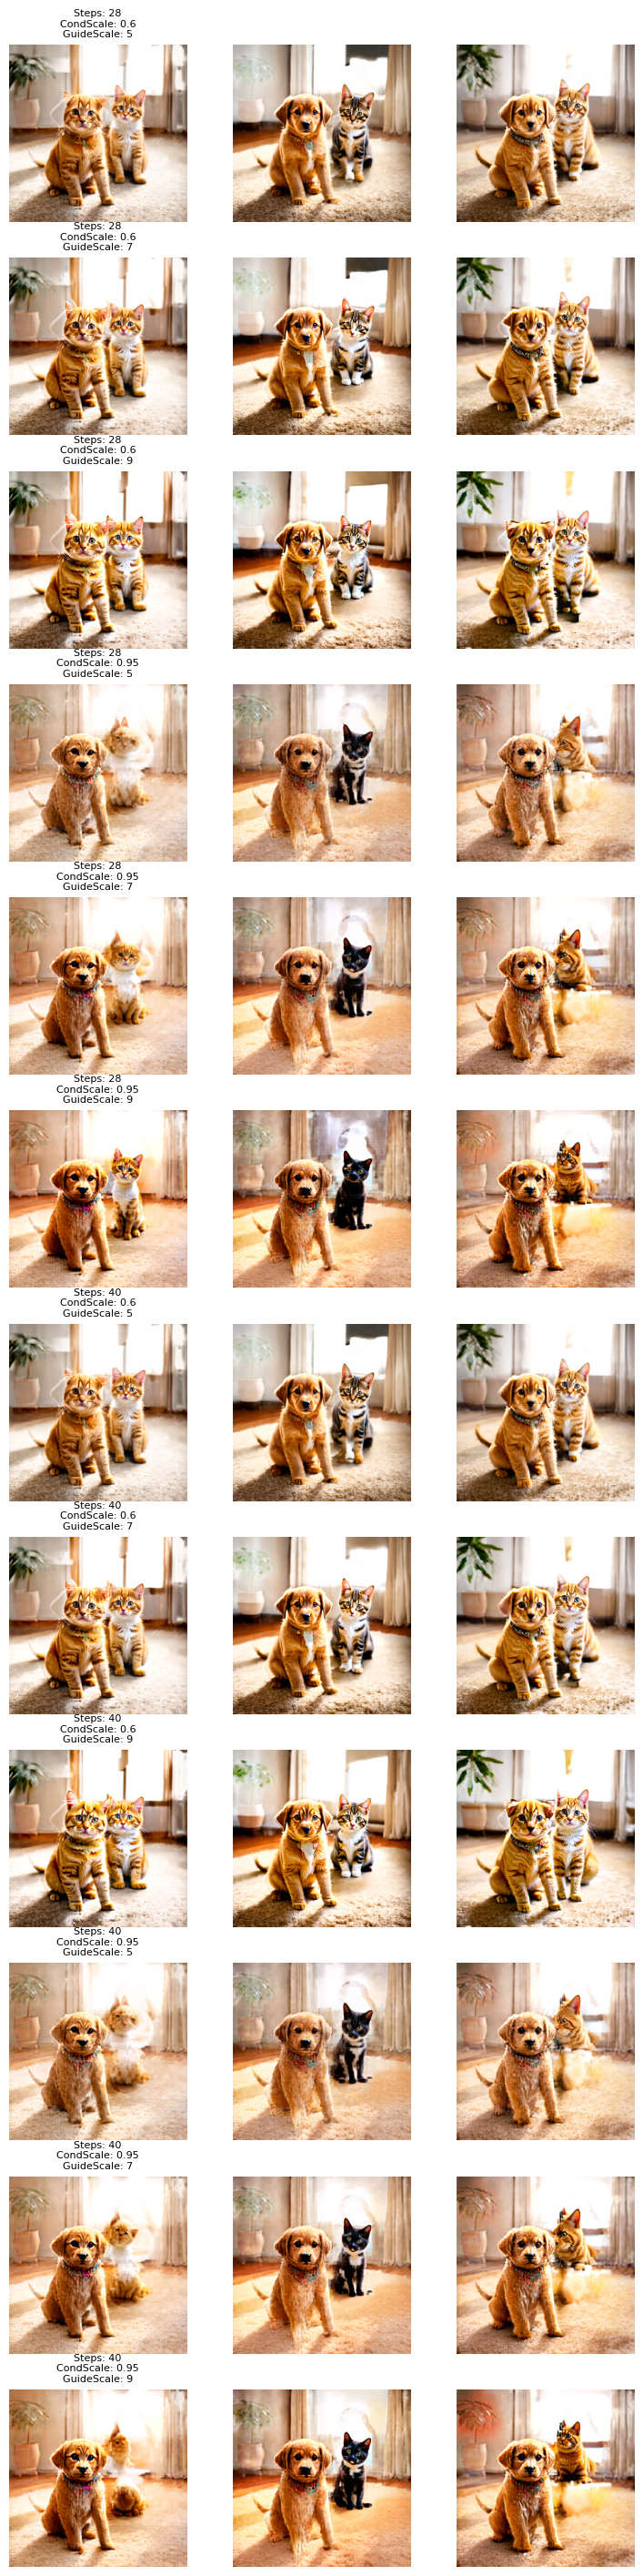

In [42]:
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict


sorted_results = sorted(
    results_dict.items(),
    key=lambda x: (x[0][0], x[0][1], x[0][2], x[0][3])  # Sort by steps, cond_scale, guide_scale, trial
)

config_2_images = defaultdict(list)
for (steps, cond_scale, guide_scale, trial), filename in results_dict.items():
    config_2_images[(steps, cond_scale, guide_scale)].append(filename)


fig, ax = plt.subplots(nrows=len(config_2_images), ncols=3, figsize=(3 * 3, len(config_2_images) * 3))

for i, (k, v) in enumerate(config_2_images.items()):
    steps, cond_scale, guide_scale = k
    for j, filename in enumerate(v):
        image = Image.open(os.path.join(output_dir, filename))
        ax[i, j].imshow(image)
        ax[i, j].axis("off")
        if j == 0:
            ax[i, j].set_title(f"Steps: {steps}\nCondScale: {cond_scale}\nGuideScale: {guide_scale}", fontsize=8)

fig.savefig(os.path.join(output_dir, "grid_search_results.png"))

In [ ]:
from datetime import datetime
import os
import time

model_name = "alimama-creative/SD3-Controlnet-Inpainting".replace('/', '_')

for i in range(3):
    data_dir = os.environ["DATA_DIR"]
    output_dir = os.path.join(data_dir, "outputs", model_name)
    run_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    output_dir = os.path.join(output_dir, run_timestamp)
    os.makedirs(output_dir, exist_ok=True)

    seed = int(time.time()) % 2**32
    generator = torch.Generator("cpu").manual_seed(seed)

    for task in tasks:
        image = load_and_preprocess_image(os.path.join(data_dir, task.source_image))
        mask = load_and_preprocess_mask(os.path.join(data_dir, task.mask_image))

        inpainted_image = pipe(
            prompt=task.prompt,
            negative_prompt=task.negative_prompt,
            height=image.size[1],
            width=image.size[0],
            control_image=image,
            control_mask=mask,
            num_inference_steps=28,
            generator=generator,
            controlnet_conditioning_scale=0.95,
            guidance_scale=7,
        ).images[0]

        output_path = os.path.join(output_dir, f"{task.task_id}.png")
        inpainted_image.save(output_path)

# Stable Diffusion XL Inpainting

https://huggingface.co/diffusers/stable-diffusion-xl-1.0-inpainting-0.1

In [ ]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch

pipe = (
    AutoPipelineForInpainting
    .from_pretrained(
        "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
        torch_dtype=torch.float16,
        variant="fp16",
        cache_dir=os.environ["HUGGING_FACE_CACHE_DIR"]
    )
    .to("cuda")
)

In [ ]:
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

image = load_image(img_url).resize((1024, 1024))
mask_image = load_image(mask_url).resize((1024, 1024))

prompt = "a tiger sitting on a park bench"
generator = torch.Generator(device="cuda").manual_seed(0)

inpainted_image = pipe(
  prompt=prompt,
  image=image,
  mask_image=mask_image,
  guidance_scale=8.0,
  num_inference_steps=20,  # steps between 15 and 30 work well for us
  strength=0.99,  # make sure to use `strength` below 1.0
  generator=generator,
).images[0]

(-0.5, 1023.5, 1023.5, -0.5)

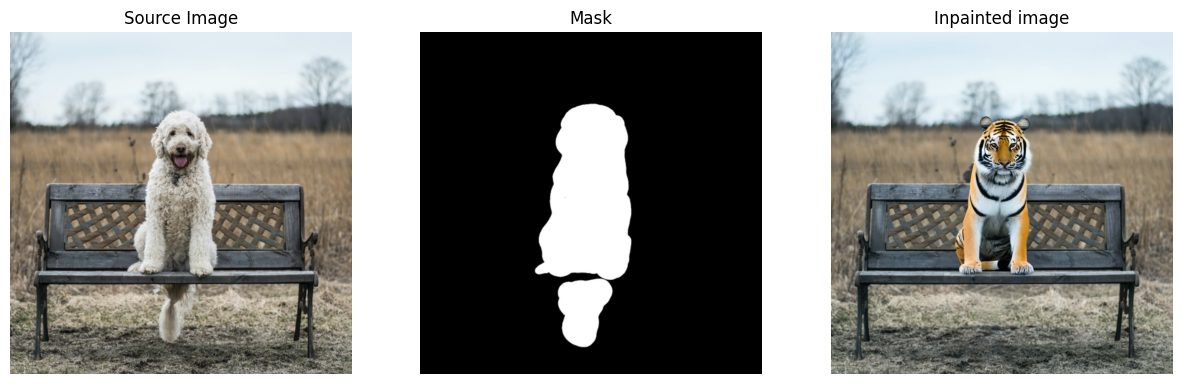

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Source Image")
ax[0].axis("off")

ax[1].imshow(mask_image)
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(inpainted_image)
ax[2].set_title("Inpainted image")
ax[2].axis("off")

In [ ]:
from datetime import datetime
import os
import time

model_name = "diffusers/stable-diffusion-xl-1.0-inpainting-0.1".replace('/', '_')

for i in range(3):
    data_dir = os.environ["DATA_DIR"]
    output_dir = os.path.join(data_dir, "outputs", model_name)
    run_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    output_dir = os.path.join(output_dir, run_timestamp)
    os.makedirs(output_dir, exist_ok=True)

    seed = int(time.time()) % 2**32
    generator = torch.Generator("cpu").manual_seed(seed)

    for task in tasks:
        image = load_and_preprocess_image(os.path.join(data_dir, task.source_image))
        mask = load_and_preprocess_mask(os.path.join(data_dir, task.mask_image))

        inpainted_image = pipe(
            prompt=task.prompt,
            image=image,
            mask_image=mask_image,
            guidance_scale=8.0,
            num_inference_steps=20,  # steps between 15 and 30 work well for us
            strength=0.99,  # make sure to use `strength` below 1.0
            generator=generator,
        ).images[0]

        output_path = os.path.join(output_dir, f"{task.task_id}.png")
        inpainted_image.save(output_path)

# Stable-diffusion-2-inpainting

https://huggingface.co/stabilityai/stable-diffusion-2-inpainting

In [ ]:
# del pipe
# torch.cuda.empty_cache()

# import gc
# gc.collect()

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch

pipe = (
    StableDiffusionInpaintPipeline
    .from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16,
        cache_dir=os.environ["HUGGING_FACE_CACHE_DIR"]
    )
)
pipe.to("cuda")

  0%|          | 0/29 [00:00<?, ?it/s]

(-0.5, 511.5, 511.5, -0.5)

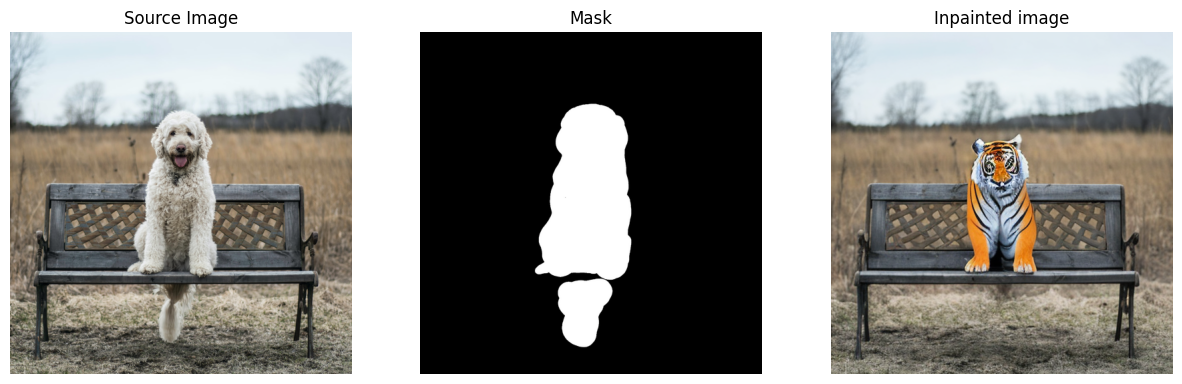

In [10]:
from diffusers.utils import load_image

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

image = load_image(img_url).resize((512, 512))
mask_image = load_image(mask_url).resize((512, 512))

prompt = "a tiger sitting on a park bench"

generator = torch.Generator(device="cuda").manual_seed(0)

inpainted_image = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    guidance_scale=8.0,
    num_inference_steps=30,
    strength=0.99,
    generator=generator,
).images[0]

import matplotlib.pyplot as plt
%matplotlib inline


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Source Image")
ax[0].axis("off")

ax[1].imshow(mask_image)
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(inpainted_image)
ax[2].set_title("Inpainted image")
ax[2].axis("off")

In [ ]:
from datetime import datetime
import os
import time

model_name = "stabilityai/stable-diffusion-2-inpainting".replace('/', '_')

for i in range(3):
    data_dir = os.environ["DATA_DIR"]
    output_dir = os.path.join(data_dir, "outputs", model_name)
    run_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    output_dir = os.path.join(output_dir, run_timestamp)
    os.makedirs(output_dir, exist_ok=True)

    seed = int(time.time()) % 2**32
    generator = torch.Generator("cpu").manual_seed(seed)

    for task in tasks:
        image = load_and_preprocess_image(os.path.join(data_dir, task.source_image), target_res=(512, 512))
        mask = load_and_preprocess_mask(os.path.join(data_dir, task.mask_image), target_res=(512, 512))
        prompt = task.prompt

        inpainted_image = pipe(
            prompt=prompt,
            image=image,
            mask_image=mask_image,
            guidance_scale=8.0,
            num_inference_steps=30,
            strength=0.99,
            generator=generator,
        ).images[0]

        output_path = os.path.join(output_dir, f"{task.task_id}.png")
        inpainted_image.save(output_path)

# Kandinsky-2-2-decoder-inpaint

https://huggingface.co/kandinsky-community/kandinsky-2-2-decoder-inpaint

In [ ]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch
import numpy as np

pipe = AutoPipelineForInpainting.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder-inpaint",
    torch_dtype=torch.float16,
    cache_dir=os.environ["HUGGING_FACE_CACHE_DIR"]
)
pipe.to("cuda")

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

(-0.5, 767.5, 767.5, -0.5)

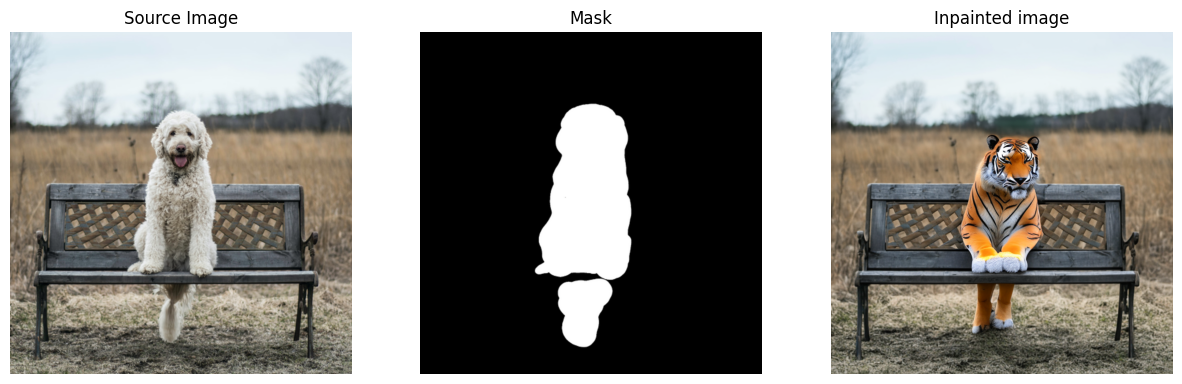

In [23]:
from diffusers.utils import load_image


TARGET_RES = (768, 768)

prompt = "a tiger sitting on a park bench"

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

image = load_image(img_url).resize(TARGET_RES)
mask_image = load_image(mask_url).resize(TARGET_RES)


generator = torch.Generator(device="cuda").manual_seed(0)

out = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image,
    height=TARGET_RES[0],
    width=TARGET_RES[1],
    num_inference_steps=150,
    generator=generator
)

inpainted_image = out.images[0]


import matplotlib.pyplot as plt
%matplotlib inline


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image)
ax[0].set_title("Source Image")
ax[0].axis("off")

ax[1].imshow(mask_image)
ax[1].set_title("Mask")
ax[1].axis("off")

ax[2].imshow(inpainted_image)
ax[2].set_title("Inpainted image")
ax[2].axis("off")

In [ ]:
from datetime import datetime
import os
import time

TARGET_RES = (768, 768)
model_name = "kandinsky-community/kandinsky-2-2-decoder-inpaint".replace('/', '_')

for i in range(3):
    data_dir = os.environ["DATA_DIR"]
    output_dir = os.path.join(data_dir, "outputs", model_name)
    run_timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    output_dir = os.path.join(output_dir, run_timestamp)
    os.makedirs(output_dir, exist_ok=True)

    seed = int(time.time()) % 2**32
    generator = torch.Generator("cpu").manual_seed(seed)

    for task in tasks:
        image = load_and_preprocess_image(os.path.join(data_dir, task.source_image), target_res=TARGET_RES)
        mask = load_and_preprocess_mask(os.path.join(data_dir, task.mask_image), target_res=TARGET_RES)
        prompt = task.prompt

        inpainted_image = pipe(
            prompt=prompt,
            image=image,
            mask_image=mask_image,
            height=TARGET_RES[0],
            width=TARGET_RES[1],
            num_inference_steps=150,
            generator=generator
        ).images[0]

        output_path = os.path.join(output_dir, f"{task.task_id}.png")
        inpainted_image.save(output_path)